In [14]:
import pandas as pd
import numpy as np
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats

In [ ]:
# Change data paths to your own
metadata = pd.read_csv("~/Desktop/processed_metadata.txt", sep="\t")
cluster_labels = pd.read_csv("~/Desktop/5k_PCA_clustering_labels_df.tsv", sep="\t")

# Choose which method to use for clustering if you df has multiple clustering method labels
cluster_labels = cluster_labels.loc[:, ["sample_id", "kmeans_cluster_label"]]

In [24]:
# reomve metastatic samples
filtered_cluster_labels = cluster_labels[cluster_labels["sample_id"].apply(lambda x: not x.split('-')[3].startswith("06"))]

# Extract patient IDs
filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]
filtered_cluster_labels = filtered_cluster_labels.rename(columns={"kmeans_cluster_label": "cluster"})
df = pd.merge(filtered_cluster_labels, metadata, on='patient_id')
df = df.drop(columns=["sample_id"])


/var/folders/_k/b8vsv8097ss3sxnsdwkx1y_80000gn/T/ipykernel_53234/4094976798.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cluster_labels["patient_id"] = ['-'.join(barcode.split('-')[:3]) for barcode in filtered_cluster_labels["sample_id"]]


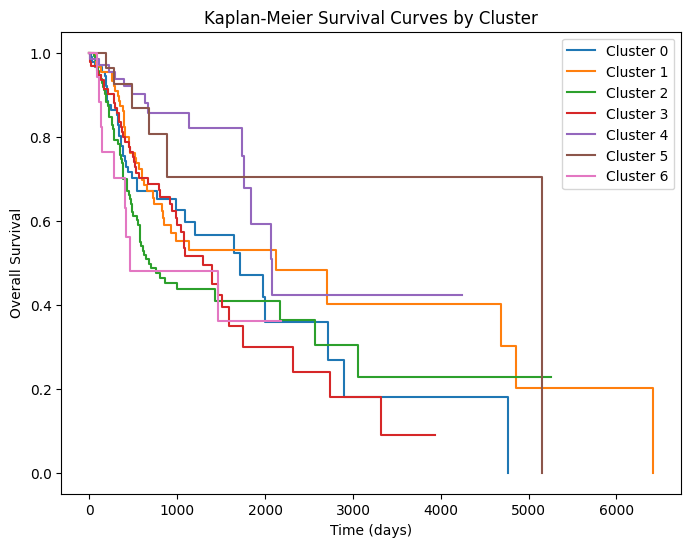

   test_statistic         p   -log2(p)
0       23.905562  0.000544  10.845264


<lifelines.CoxPHFitter: fitted with 499 total observations, 283 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 499
number of events observed = 216
   partial log-likelihood = -1162.91
         time fit was run = 2025-04-13 18:11:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
cluster_1 -0.19      0.83      0.23           -0.64            0.26                0.53                1.30
cluster_2  0.26      1.29      0.21           -0.15            0.66                0.86                1.94
cluster_3  0.09      1.09      0.22           -0.34            0.52                0.71                1.68
cluster_4 -0.91      0.40      0.31           -1.52           -0.29                0.22                0.75
cluster_5 -0.80      0.45      0.44           -1.66            0.07                0.19                1.07
cluster_6  0.37      1.44      0.37           -0.36            1.09                0.70                2.99

           cmp to     z      p  -log2(p)
covariate                               
cluster_1    0.00 -0.83   0.41      1.29
cluster_2    0.00  1.25   0.21      2.24
cluster_3    0.00  0.41   0.69      0.54
cluster_4    0.00 -2.89 <0.005      8.03
cluster_5    0.00 -1.81   0.07      3.82
cluster_6    0.00  0.99   0.32      1.63
---
Concordance = 0.61
Partial AIC = 2337.81
log-likelihood ratio test = 26.51 on 6 df
-log2(p) of ll-ratio test = 12.45

In [9]:
# -------------------------------------------------
# Kaplan-Meier Estimation and Visualization
# -------------------------------------------------
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

# Loop through each cluster, fit, and plot the survival function
for cluster, cluster_df in df.groupby('cluster'):
    kmf.fit(cluster_df['time'], event_observed=cluster_df['event'], label=f'Cluster {cluster}')
    kmf.plot_survival_function(ci_show=False)  # Plot survival function with confidence intervals

plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.xlabel("Time (days)")
plt.ylabel("Overall Survival")
plt.legend()
plt.show()

# -------------------------------------------------
# Multivariate Log-Rank Test for Comparing Survival Curves
# -------------------------------------------------
# The multivariate_logrank_test function compares the survival distribution
# across all groups at once.
logrank_results = multivariate_logrank_test(df['time'], df['cluster'], event_observed=df['event'])
print(logrank_results.summary)

# -------------------------------------------------
# Cox Proportional Hazards Model for Hazard Ratios
# -------------------------------------------------
# Ensure the "cluster" column is treated as a categorical variable.
# Here we convert it to string and then create dummy variables.
df['cluster'] = df['cluster'].astype(str)
df_encoded = pd.get_dummies(df[['cluster']], drop_first=True)  # drop_first to set a reference level
df_model = pd.concat([df[['time', 'event']], df_encoded], axis=1)

cph = CoxPHFitter()
cph.fit(df_model, duration_col='time', event_col='event')
cph.print_summary()  # Displays hazard ratios, confidence intervals, and p-values


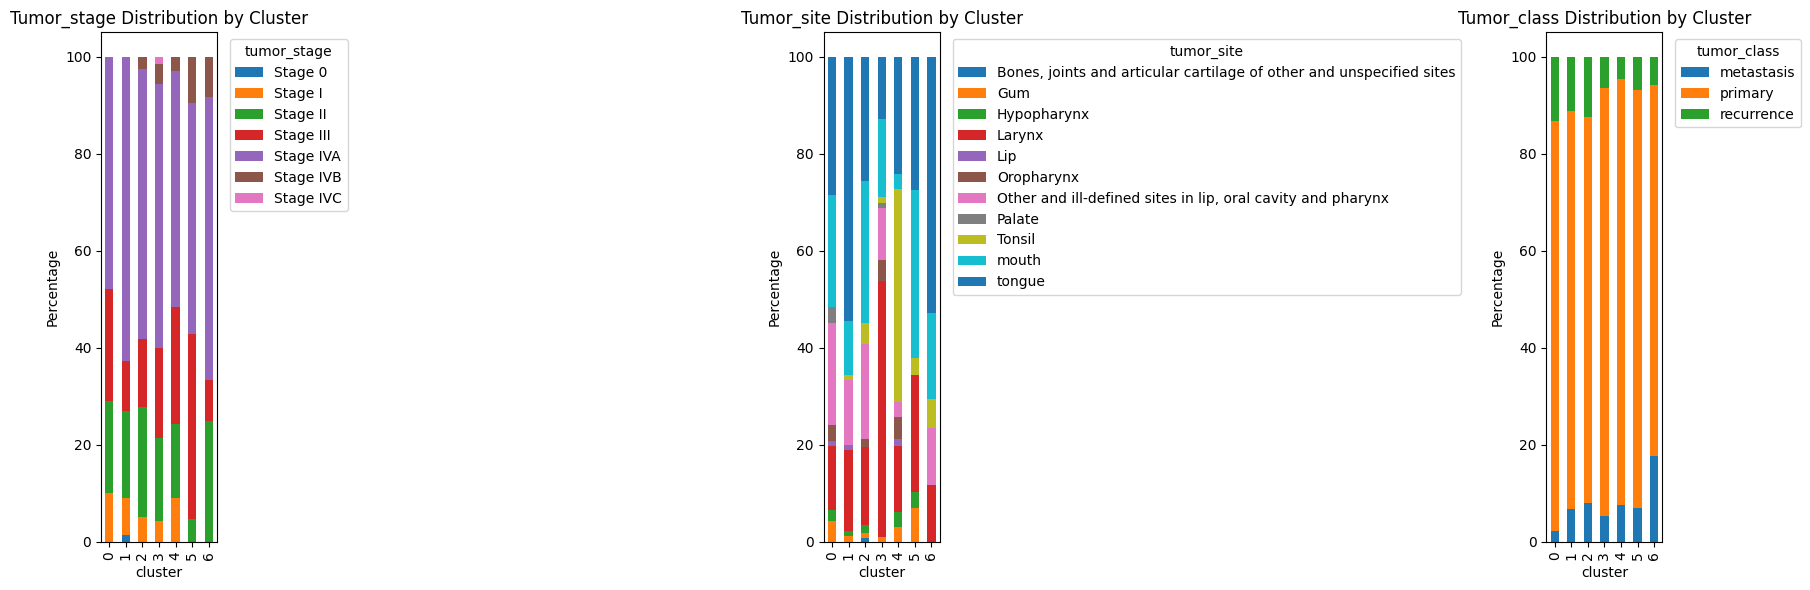

In [11]:
# ============================================================
# Creating Stacked Bar Plots for Each Categorical Variable
# ============================================================
# We will produce one stacked bar plot per variable.
# In each plot the x-axis corresponds to the groups (here: clusters)
# and the bars show the relative percentages of each category for the variable.

variables = ['tumor_stage', 'tumor_site', 'tumor_class']

# Create one subplot per variable
fig, axes = plt.subplots(1, len(variables), figsize=(6 * len(variables), 6))

# Iterate over the variables and plot each as a stacked bar chart
for ax, var in zip(axes, variables):
    # Create a contingency table of cluster vs the current variable.
    # The option normalize='index' computes the proportions within each cluster,
    # and multiplying by 100 converts those to percentages.
    ct = pd.crosstab(df['cluster'], df[var], normalize='index') * 100
    
    # Plot the stacked bar chart.
    ct.plot(kind='bar', stacked=True, ax=ax)
    
    # Set labels and title.
    ax.set_ylabel('Percentage')
    ax.set_title(f'{var.capitalize()} Distribution by Cluster')
    
    # Place the legend outside for better readability.
    ax.legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout so the subplots don’t overlap.
plt.tight_layout()
plt.show()

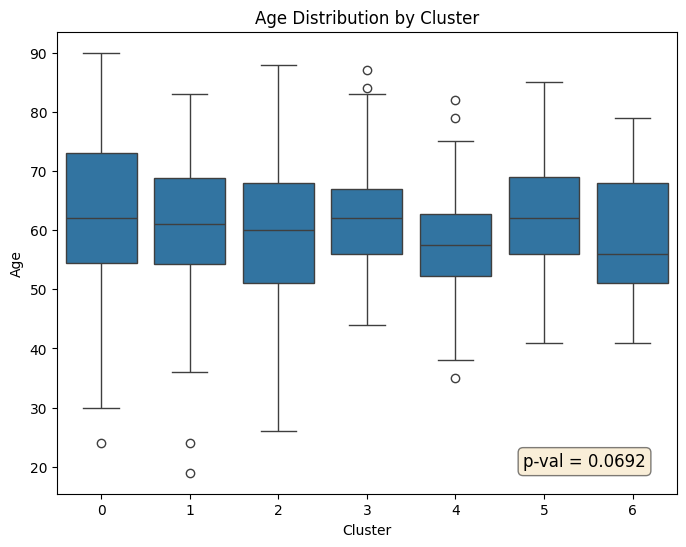

In [22]:
# ============================================================
# Create Boxplot: Age distribution by Cluster
# ============================================================
order = sorted(df['cluster'].unique())

groups = [df[df['cluster'] == cluster]['age'] for cluster in df['cluster'].unique()]
anova_result = stats.f_oneway(*groups)
p_val = anova_result.pvalue

plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='age', data=df, order=order)
plt.title('Age Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age')

ax = plt.gca()
ax.text(0.95, 0.05, f"p-val = {p_val:.4f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()